In [0]:
import multiprocessing 
print(multiprocessing.cpu_count())

40


In [0]:
import numpy as np

In [0]:
import cvxopt
import pandas as pd
import numpy as np
from cvxopt import solvers, matrix
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt  
import math
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm, tqdm_notebook
from sklearn.svm import SVC
from scipy.spatial.distance import pdist, squareform
import scipy
import joblib
from itertools import combinations
from joblib import Parallel, delayed

In [0]:
# arr = np.ones(10**9, dtype='float128')

In [0]:
gama = 0.05

In [0]:
train_path = "/content/drive/My Drive/ML/fashion_mnist/train.csv"
test_path = "/content/drive/My Drive/ML/fashion_mnist/test.csv"
val_path = "/content/drive/My Drive/ML/fashion_mnist/val.csv"

In [0]:
def readData(path, c1, c2):
	data = pd.read_csv(path, header=None)

	last_column = data.shape[1]-1
	data = filterData(c1, c2, data)

	# y_data = setY_1(data[last_column], c2, c1)
	x_data = scaleData(data.drop(last_column,1))
	y_data = data[last_column]

	return np.array(x_data), np.array(y_data).reshape(-1,1)


In [0]:
def readDataUnfiltered(path):
    data = pd.read_csv(path, header=None)

    last_column = data.shape[1]-1
    # data = filterData(c1, c2, data)

    x_data = scaleData(data.drop(last_column,1))
    y_data = data[last_column]


    return np.array(x_data), np.array(y_data).reshape(-1,1)

In [0]:
def filterData(c1, c2, data):
	last_column = data.shape[1]-1

	r_data = data[(data[last_column]==c1) | (data[last_column]==c2)]
	return r_data 

In [0]:
def setY_1(y, pos_class, neg_class):
    y[y==pos_class] = 1
    y[y==neg_class] = -1

    return y


In [0]:
def scaleData(data):
    return data / 255

In [0]:
def getP(y_train, x_train, kernel):
    m = y_train.shape[0]
    KernelMatrix = None
    if kernel == linear_kernel:
        KernelMatrix = (x_train@x_train.T)
        P = (y_train@y_train.T) * KernelMatrix
        return matrix(P), KernelMatrix
    if kernel == gaussian_kernel:
        # pairwise_sq_dists = squareform(pdist(x_train, 'sqeuclidean'))
        # KernelMatrix = np.exp(-pairwise_sq_dists * gama)
        KernelMatrix = np.exp( -gama*(cdist(x_train, x_train,'sqeuclidean')))
        P = (y_train@y_train.T) * KernelMatrix
        # print("y")
        # print(y_train)
        # print("yy.t")
        # print(y_train@y_train.T)
        # print("k")
        # print(KernelMatrix)

        return matrix(P), KernelMatrix

In [0]:

def getq(m):
    q = -np.ones((m,1))
    return matrix(q)


In [0]:
def getGh(m, C):
    G1 = np.identity(m)
    G = np.vstack((-G1, G1))

    H1 = np.zeros((m,1))
    H2 = C * np.ones((m,1))
    h = np.vstack((H1, H2))

    return matrix(G), matrix(h)


In [0]:
def getAb(y_train):
    A = y_train.T
    b = np.zeros(1)
    return matrix(A), matrix(b)


In [0]:
def linear_kernel(x, z):
    return (x.T)@z


In [0]:
def gaussian_kernel(x, z):
    return np.exp((-np.linalg.norm(x-z)**2) * gama)

In [0]:
def getWtX(alpha, Y, X, x, kernel):
    m = Y.shape[0]
    ans = 0
    for i in range(m):
        if(alpha[i]==0):
            continue
        ans+= alpha[i] * Y[i] * kernel(X[i].reshape(-1,1), x.reshape(-1,1))
    return ans


In [0]:
def getb(alpha, Y, X, kernel):
    print("calculating b")
    ans = 0
    m = Y.shape[0]
    max1 = -float('inf')
    min1 = float('inf')
    for i in tqdm(range(m)):
        wtx = getWtX(alpha, Y, X, X[i], kernel)
        if Y[i] == -1:
            max1 = max(max1, wtx)
        elif Y[i] == 1:
            min1 = min(min1, wtx)

    b = -1*(max1 + min1)/2
    # print("b", b)
    return b

In [0]:
def getGaussb(alpha,alpha_f, X, X_f, Y, Y_f, kernalMatrix):
  # print("alpha_f",alpha_f.shape)
  # print("Y_f",Y_f.shape)
  # print("X_f",X_f.shape)
  # print("X",X.shape)
  wtx = (   np.exp(-1*cdist(X, X_f, "sqeuclidean")*gama) @ (alpha_f*Y_f) )
  # print("wtx",wtx.shape)
  t1 = np.max(wtx[np.where(Y==-1)])
  t2 = np.min(wtx[np.where(Y==1)])
  b = -1 * (t1 + t2) /2
  # print("gb", b)
  return b




In [0]:

def calculateAccuracy(actual, predicted):
    count = 0
    for y1, y2 in zip(actual, predicted):
        if y1==y2:
            count+=1
    return count/len(predicted)

In [0]:
def plot_cm(actual, predicted,title="Confusion Matrix" ,labels=None):
    cm = confusion_matrix(actual, predicted, labels=labels)
    df_cm = pd.DataFrame(cm, columns=np.unique(actual), index = np.unique(actual))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (11,9))
    sns.set(font_scale=1.4)#for label size
    plt.title(title)

    ax = sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size
    bottom, top = ax.get_ylim()
    # ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

In [0]:
class MulSVM:

    def replaceLabelsBefore(self, y):
      y = np.where(y==self.neg_class, -1, y)
      y = np.where(y==self.pos_class, 1, y)
      return y

    def replaceLabelsAfter(self, y):
      # print("replaceLabelsAfter")
      # print(y)
      # y = np.where(y==100, self.pos_class, y)
      # print(self.pos_class)
      y = np.where(y==1, self.pos_class, y)
      # print(y)
      # print(y.max())
      # print(y.min())
      y = np.where(y==-1, self.neg_class, y)
      # print(y)
      # print(y.max())
      # print(y.min())
      return y

    def predictGauss(self, X_test):
        # kernel = self.kernel
        alpha_f = self.alpha_f
        x_f = self.x_f
        y_f= self.y_f
        c2 = self.pos_class
        c1 = self.neg_class

        b = self.b
        # print("Predicting")
        wtx =  np.exp(-1*cdist(X_test, x_f, "sqeuclidean")*gama) @ (alpha_f*y_f) 
        # print("Prediction Done..")
        # print("-"*30)
        return self.replaceLabelsAfter(np.sign(wtx+b)), wtx+b
    
    

    def predict(self, test_x, test_y):
        c2 = self.pos_class
        c1 = self.neg_class
        print(f"pos: {c2}, neg: {c1}")

        kernel = self.kernel
        if kernel ==gaussian_kernel:
          pred_y, confidence = self.predictGauss(test_x)
          return pred_y, confidence
        # alpha = self.alpha
        # Y = self.Y
        # X = self.X
        # b = self.b
        # p =  np.array([ 1  if getWtX(alpha, Y, X, el, kernel) + b > 0 else -1  for el in tqdm(X_test)])
        # p = self.replaceLabelsAfter(p)
        # return np.array(p).astype(int)

    def fit(self, c1, c2, x, y ):
        print(f"pos: {c2}, neg: {c1}")
        kernel = gaussian_kernel
        self.pos_class = c2
        self.neg_class = c1
        self.kernel = kernel

        # print("Reading Data")
        train_x, train_y = x,y
        train_y = self.replaceLabelsBefore(train_y)
        # print("replaceLabelsBefore")
        # print(train_y)

        cut_off = 1e-5
        C = 1
        m,n = train_x.shape
        # print("Calculating P")
        P, KernelMatrix = getP(train_y, train_x, kernel)
        q = getq(m)
        G, h = getGh(m, C)
        A, b = getAb(train_y)

        # self.KernelMatrix = KernelMatrix
        solvers.options["show_progress"] = False
        # print("CVXOPT is runnung")
        sol = solvers.qp(P,q,G,h,A,b)
        # print(sol['x'])

        alpha = np.array(sol['x']).reshape(-1,1)

        count_sv = len(alpha[alpha>cut_off])
        # print(f"No. of support vectors:",  count_sv)

        alpha_index = alpha>cut_off
        alpha[alpha<cut_off] = 0

        alpha_index1 = np.where(alpha_index)[0]

        train_x_f = np.take(train_x, alpha_index1, axis=0)

        alpha_f = (alpha*alpha_index)
        alpha_f = (alpha_f[alpha_f!=0]).reshape(-1,1)

        train_y_f = (train_y*alpha_index)
        train_y_f = (train_y_f[train_y_f!=0]).reshape(-1,1)
        if kernel == gaussian_kernel:
          b = getGaussb(alpha,alpha_f, train_x, train_x_f, train_y, train_y_f, KernelMatrix)
        # else:
        #   b = getb(alpha_f, train_y_f, train_x_f, kernel)
        # bb = getbb(alpha, train_x,train_y, KernelMatrix)
        

        # self.bb = bb
        self.count_sv = count_sv
        self.alpha_f = alpha_f
        self.x_f = train_x_f
        self.y_f = train_y_f
        self.b = b
        # self.w = None

        self.alpha = alpha
        # self.X = train_x
        # self.Y = train_y

      
        # print("Training Done..")
        

        # if kernel == linear_kernel:
        #     w = np.sum(train_y_f * alpha_f * train_x_f, axis=0).reshape(-1,1)
        #     self.w = w

        return True
        
       

# Training on 45 models

In [0]:
base_path = "/content/drive/My Drive/ML/SVM/MultiClass2/"

In [0]:
from itertools import  combinations

In [0]:
comb_list = list(combinations(range(10) , 2))

In [0]:
train_x, train_y = readDataUnfiltered(train_path)

In [0]:
filterData()

In [0]:
def pl_Fit(i,j):
    model_name = str(i)+"_"+str(j)
    MulSVM_model = MulSVM()
    x_ij, y_ij = readData(train_path, i,j)
    MulSVM_model.fit(i,j,x_ij, y_ij)
    return MulSVM_model



In [0]:
comb_list

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 8),
 (7, 9),
 (8, 9)]

In [0]:
out = Parallel(n_jobs=10)(delayed(pl_Fit)(i,j) for i,j in comb_list)

In [0]:
joblib.dump(out, base_path+"out")

In [0]:
test_x, test_y = readData(test_path, 0, 1)

In [0]:
out[20].pos_class

6

In [0]:
p,a = out[0].predictGauss(test_x)

In [0]:
calculateAccuracy(p, test_y)

0.993

# Prediction on 45 models

In [0]:
def pl_pred(test_ex, model):
    pred,conf = model.predictGauss(test_ex.reshape(1,-1))
    pred = int(pred[0][0])
    conf = int(conf[0][0])
    return pred, conf

In [0]:
def predictMulti(test):
    test_count = test.shape[0]
    m_vote = np.zeros((test_count,10))
    m_conf = np.zeros((test_count,10))

    for i in tqdm(range(len(comb_list))):
        model = out[i]
        output =  Parallel(n_jobs=-1)(delayed(pl_pred)(test[i], model) for i in (range(test_count)))
        for test_no, el in enumerate(output):
                pred, conf = el
                # pred = int(pred[0][0])
                # conf = int(conf[0][0])

                m_vote[test_no][pred] = m_vote[test_no][pred] + 1
                m_conf[test_no][pred] = m_conf[test_no][pred] + abs(conf)

    p = np.argmax(m_vote, axis=1)
    return p, m_vote, m_conf

In [0]:
test_x, test_y = readDataUnfiltered(test_path)

In [0]:
val_x, val_y = readDataUnfiltered(val_path)

In [0]:
p, mv, mc = predictMulti(test_x)


100%|██████████| 45/45 [22:11<00:00, 29.23s/it]


In [0]:
acc1 = calculateAccuracy(p ,test_y)

In [0]:
acc1

0.8506

In [0]:
f1_test = f1_score(test_y, p, average="weighted")

In [0]:
f1_test

0.8513590364003317

In [0]:
print("Accuracy on Test",acc1 )
print("F1 score on Test", f1_test)

Accuracy on Test 0.8506
F1 score on Test 0.8513590364003317


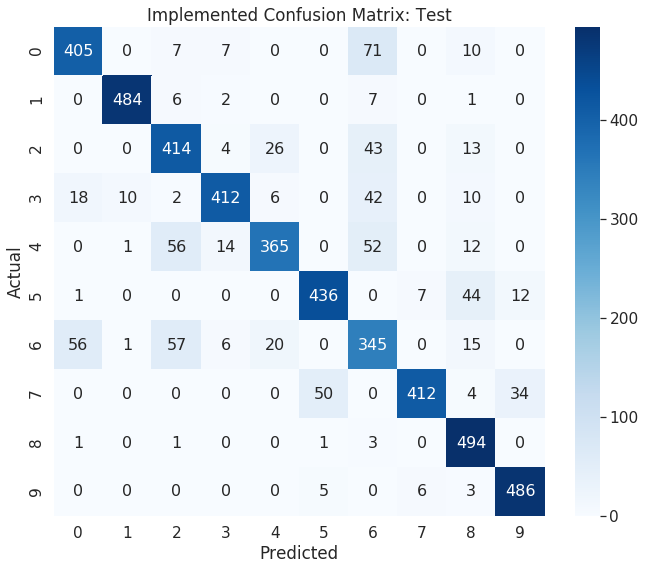

In [0]:
plot_cm(test_y.astype(int), p.astype(int), title="Implemented Confusion Matrix: Test")

In [0]:
p_val, mv_val, mc_val = predictMulti(val_x)


100%|██████████| 45/45 [11:27<00:00, 14.90s/it]


In [0]:
acc_val = calculateAccuracy(p_val ,val_y)
f1_val = f1_score(val_y, p_val, average="weighted")

print("Accuracy on Val",acc_val )
print("F1 score on Val", f1_val)

Accuracy on Val 0.8504
F1 score on Val 0.8506360017907653


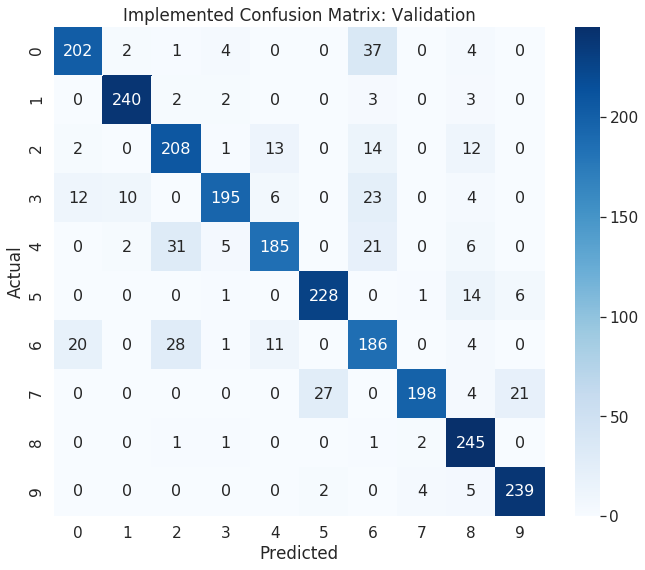

In [0]:
plot_cm(val_y.astype(int), p_val.astype(int), title="Implemented Confusion Matrix: Validation")